In [ ]:
!pip install datasets
!pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import torch
import json
import pandas as pd
import numpy as np
from datasets import load_dataset, load_metric

torch.backends.cuda.max_split_size_mb = 1024
# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
# import datasets

In [ ]:
# dataset = load_dataset("textvqa")
# train_data, val_data = dataset["train"], dataset["validation"]

In [ ]:
train_data_dict = train_data.to_dict()

In [ ]:
# train_data_dict.keys()

In [ ]:
# %mkdir textvqa

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

vit_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)



max_length = 64
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(example):
  images = []
  # for image_path in image_paths:
  #   i_image = Image.open(image_path)
  #   if i_image.mode != "RGB":
  #     i_image = i_image.convert(mode="RGB")
  image = example["image"]
  
  if image:
    if image.mode != "RGB":
      image = image.convert(mode="RGB")
    images.append(image)

    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = vit_model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]

    example["captions"] = preds[0]
  else:
    example["captions"] = ""
  return example

In [ ]:
#Mapping the predict_step function to generate image captions for training set
train_data_captions = train_data.map(predict_step)

Map:   0%|          | 0/34602 [00:00<?, ? examples/s]

In [ ]:
train_data_captions[0]

{'image_id': '0054c91397f2fe05',
 'question_id': 0,
 'question': 'what is the brand of phone?',
 'question_tokens': ['what', 'is', 'the', 'brand', 'of', 'phone'],
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x730 at 0x7F7683033370>,
 'image_width': 1024,
 'image_height': 730,
 'flickr_original_url': 'https://farm6.staticflickr.com/2891/9134076951_f65b421097_o.jpg',
 'flickr_300k_url': 'https://c4.staticflickr.com/3/2891/9134076951_9db89d3e0f_z.jpg',
 'answers': ['nokia',
  'nokia',
  'nokia',
  'nokia',
  'toshiba',
  'nokia',
  'nokia',
  'nokia',
  'nokia',
  'nokia'],
 'image_classes': ['Belt',
  'Headphones',
  'Goggles',
  'Scale',
  'Bottle opener',
  'Mobile phone',
  'Mirror',
  'Digital clock',
  'Television',
  'Telephone',
  'Tool',
  'Wheel',
  'Camera',
  'Watch',
  'Glasses',
  'Aircraft'],
 'set_name': 'train',
 'captions': 'a black and white photo of a cell phone'}

In [ ]:
len(val_data)

5000

In [ ]:
#Mapping the predict_step function to generate image captions for training set
val_data_captions = val_data.map(predict_step)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
val_data_captions[0]

{'image_id': '003a8ae2ef43b901',
 'question_id': 34602,
 'question': 'what is the brand of this camera?',
 'question_tokens': ['what', 'is', 'the', 'brand', 'of', 'this', 'camera'],
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x664 at 0x7F7683627730>,
 'image_width': 1024,
 'image_height': 664,
 'flickr_original_url': 'https://farm2.staticflickr.com/4/5566811_bc00d504a6_o.jpg',
 'flickr_300k_url': 'https://farm2.staticflickr.com/4/5566811_bc00d504a6_o.jpg',
 'answers': ['nous les gosses',
  'dakota',
  'clos culombu',
  'dakota digital',
  'dakota',
  'dakota',
  'dakota digital',
  'dakota digital',
  'dakota',
  'dakota'],
 'image_classes': ['Cassette deck',
  'Printer',
  'Medical equipment',
  'Computer mouse',
  'Scale',
  'Telephone',
  'Camera',
  'Ipod',
  'Remote control'],
 'set_name': 'val',
 'captions': 'a close up picture of a cell phone'}

In [ ]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

In [ ]:
train_data_captions_dict = train_data_captions.to_dict()

In [ ]:
train_data_captions_dict.keys()

dict_keys(['image_id', 'question_id', 'question', 'question_tokens', 'image', 'image_width', 'image_height', 'flickr_original_url', 'flickr_300k_url', 'answers', 'image_classes', 'set_name', 'captions'])

In [ ]:
# train_data_captions_dict["answers"]

In [ ]:
with open('./textvqa/train_captionsdata.pickle', 'wb') as handle:
    pickle.dump(train_data_captions_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./textvqa/train_captionsdata.pickle', 'rb') as handle:
    train_data_captions_dict = pickle.load(handle)

In [ ]:
val_data_captions_dict = val_data_captions.to_dict()

In [ ]:
with open('./textvqa/valid_captionsdata.pickle', 'wb') as handle:
    pickle.dump(val_data_captions_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./textvqa/valid_captionsdata.pickle', 'rb') as handle:
    val_data_captions_dict = pickle.load(handle)

In [ ]:
#Functions to create unique list of choices and the ground truth answer
def create_choices(answers):
    choices_list = list(set(answers))
    return choices_list
def label_answer(answers):
    answer = max(answers,key=answers.count)
    return answer

In [ ]:
train_data_captions_dict["choices"] = list(map(create_choices,train_data_captions_dict["answers"]))

In [ ]:
train_data_captions_dict["answer"] = list(map(label_answer,train_data_captions_dict["answers"]))

In [ ]:
train_data_captions_new = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data_captions_dict))

In [ ]:
train_data_captions_new[0]

{'image_id': '0054c91397f2fe05',
 'question_id': 0,
 'question': 'what is the brand of phone?',
 'question_tokens': ['what', 'is', 'the', 'brand', 'of', 'phone'],
 'image': {'bytes': None,
  'path': '/root/.cache/huggingface/datasets/downloads/extracted/f8b3358ef194bf4536b05cbeff7819f8ddc108d2929f31f1662029638691522e/train_images/0054c91397f2fe05.jpg'},
 'image_width': 1024,
 'image_height': 730,
 'flickr_original_url': 'https://farm6.staticflickr.com/2891/9134076951_f65b421097_o.jpg',
 'flickr_300k_url': 'https://c4.staticflickr.com/3/2891/9134076951_9db89d3e0f_z.jpg',
 'answers': ['nokia',
  'nokia',
  'nokia',
  'nokia',
  'toshiba',
  'nokia',
  'nokia',
  'nokia',
  'nokia',
  'nokia'],
 'image_classes': ['Belt',
  'Headphones',
  'Goggles',
  'Scale',
  'Bottle opener',
  'Mobile phone',
  'Mirror',
  'Digital clock',
  'Television',
  'Telephone',
  'Tool',
  'Wheel',
  'Camera',
  'Watch',
  'Glasses',
  'Aircraft'],
 'set_name': 'train',
 'captions': 'a black and white photo o

In [ ]:
len([i for i in train_data_captions_new if i["image_id"]])

34602

In [ ]:
len(train_data_captions_new)

34602

In [ ]:
val_data_captions_dict["choices"] = list(map(create_choices,val_data_captions_dict["answers"]))
val_data_captions_dict["answer"] = list(map(label_answer,val_data_captions_dict["answers"]))

In [ ]:
val_data_captions_new = datasets.Dataset.from_pandas(pd.DataFrame(data=val_data_captions_dict))

In [ ]:
val_data_captions_new[0]

{'image_id': '003a8ae2ef43b901',
 'question_id': 34602,
 'question': 'what is the brand of this camera?',
 'question_tokens': ['what', 'is', 'the', 'brand', 'of', 'this', 'camera'],
 'image': {'bytes': None,
  'path': '/root/.cache/huggingface/datasets/downloads/extracted/f8b3358ef194bf4536b05cbeff7819f8ddc108d2929f31f1662029638691522e/train_images/003a8ae2ef43b901.jpg'},
 'image_width': 1024,
 'image_height': 664,
 'flickr_original_url': 'https://farm2.staticflickr.com/4/5566811_bc00d504a6_o.jpg',
 'flickr_300k_url': 'https://farm2.staticflickr.com/4/5566811_bc00d504a6_o.jpg',
 'answers': ['nous les gosses',
  'dakota',
  'clos culombu',
  'dakota digital',
  'dakota',
  'dakota',
  'dakota digital',
  'dakota digital',
  'dakota',
  'dakota'],
 'image_classes': ['Cassette deck',
  'Printer',
  'Medical equipment',
  'Computer mouse',
  'Scale',
  'Telephone',
  'Camera',
  'Ipod',
  'Remote control'],
 'set_name': 'val',
 'captions': 'a close up picture of a cell phone',
 'choices': 

In [ ]:
sample_train_dataset = train_data_captions_new.train_test_split(train_size=0.7, seed = 42)["train"]

In [ ]:
len(sample_train_dataset)

24221

In [ ]:
# Define the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device) 
#Change this to the new model from checkpoints.

In [ ]:
# process the examples in input and target text format and the eos token at the end 

#For answer ONLY (not solution and explanation)
def add_eos_to_examples(example):
    example['input_text'] = 'question: %s  choices: %s  context: %s </s>' % (example['question'].lower(), example['choices'], example['captions'].lower())
    example['target_text'] = 'answer: %s </s>' % ([example['answer']])
    return example

# tokenize the examples
def convert_to_features(example_batch):
    input_encodings = tokenizer.batch_encode_plus(example_batch['input_text'], pad_to_max_length=True, max_length=512, truncation=True)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target_text'], pad_to_max_length=True, max_length=128, truncation=True)
    encodings = {
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask'],
        'target_ids': target_encodings['input_ids'],
        'target_attention_mask': target_encodings['attention_mask']
    }

    return encodings

In [ ]:
#For generated examples as input:

# map add_eos_to_examples function to the dataset example wise 
train_dataset = sample_train_dataset.map(add_eos_to_examples, load_from_cache_file=False)
# map convert_to_features batch wise
train_dataset = train_dataset.map(convert_to_features, batched=True)

valid_dataset = val_data_captions_new.map(add_eos_to_examples, load_from_cache_file=False)
valid_dataset = valid_dataset.map(convert_to_features, batched=True, load_from_cache_file=False)


# set the tensor type and the columns which the dataset should return
columns = ['input_ids', 'target_ids', 'attention_mask', 'target_attention_mask']
train_dataset.set_format(type='torch', columns=columns)
valid_dataset.set_format(type='torch', columns=columns)

Map:   0%|          | 0/24221 [00:00<?, ? examples/s]

Map:   0%|          | 0/24221 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
len(train_dataset), len(valid_dataset)

(24221, 5000)

In [ ]:
# train_dataset[0]

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)

In [ ]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['input_ids', 'attention_mask', 'target_ids', 'target_attention_mask'])


In [ ]:
tokenizer.decode(batch['input_ids'][7])

"question: what does the sign say on the building on the right? choices: ['plole', 'pioloe', 'piole'] context: a city street at night with a large clock tower</s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [ ]:
tokenizer.decode(batch['target_ids'][7])

"answer: ['piole']</s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"

In [ ]:
from transformers import DataCollator, AdamW, get_linear_schedule_with_warmup
import numpy as np

In [ ]:
def data_collator(batch):
    input_ids = torch.stack([example['input_ids'] for example in batch])
    attention_mask = torch.stack([example['attention_mask'] for example in batch])

    target_ids = torch.stack([example['target_ids'] for example in batch])
    target_attention_mask = torch.stack([example['target_attention_mask'] for example in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'target_ids': target_ids,
        'target_attention_mask': target_attention_mask
    }

In [ ]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [ ]:
from tqdm import tqdm
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = 10000
num_warmup_steps = 500
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

# Define the training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_loss = []
val_loss = []
for epoch in range(5):
    print("Training: ")
    model.train(True)
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=data_collator)
    total_loss = 0
    torch.cuda.empty_cache()
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=target_ids,
            decoder_attention_mask=target_attention_mask,
            use_cache=False
        )
        
        loss = outputs.loss
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    train_epoch_loss = total_loss / len(train_dataloader) 
    train_loss.append(train_epoch_loss)
    print(f"Training Loss at epoch {epoch}: {train_epoch_loss}")

    print("Validation:")
    valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=data_collator)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target_ids = batch['target_ids'].to(device)
            target_attention_mask = batch['target_attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=target_ids,
                decoder_attention_mask=target_attention_mask,
                use_cache=False
            )

            loss = outputs.loss
            total_loss += loss.item()
    val_epoch_loss = total_loss / len(valid_dataloader) 
    val_loss.append(val_epoch_loss)
    print(f"Validation Loss at epoch {epoch}: {val_epoch_loss}")
    # val_loss.append(total_loss / len(valid_dataloader))
    # print(val_loss)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training: 


100%|██████████| 6056/6056 [17:57<00:00,  5.62it/s]


Training Loss at epoch 0: 0.48205909228804505
Validation:


100%|██████████| 1250/1250 [01:11<00:00, 17.37it/s]


Validation Loss at epoch 0: 0.008576889139041305
Training: 


100%|██████████| 6056/6056 [17:58<00:00,  5.61it/s]


Training Loss at epoch 1: 0.011513533774923129
Validation:


100%|██████████| 1250/1250 [01:12<00:00, 17.22it/s]


Validation Loss at epoch 1: 0.008320784086035565
Training: 


100%|██████████| 6056/6056 [18:00<00:00,  5.60it/s]


Training Loss at epoch 2: 0.01130285238939273
Validation:


100%|██████████| 1250/1250 [01:12<00:00, 17.22it/s]


Validation Loss at epoch 2: 0.008320784086035565
Training: 


  0%|          | 4/6056 [00:00<21:49,  4.62it/s]


KeyboardInterrupt: ignored

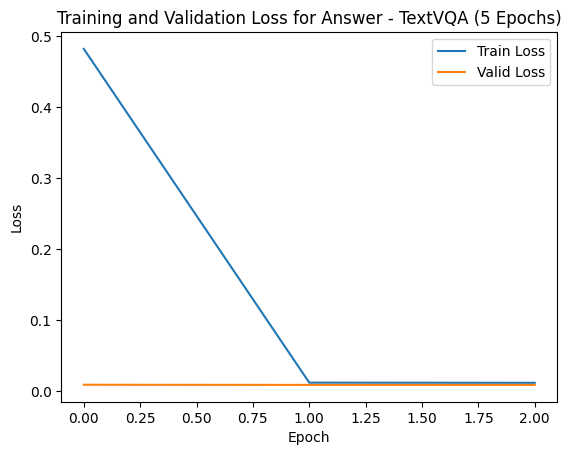

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss for Answer - TextVQA (5 Epochs)")
plt.legend()
plt.show()

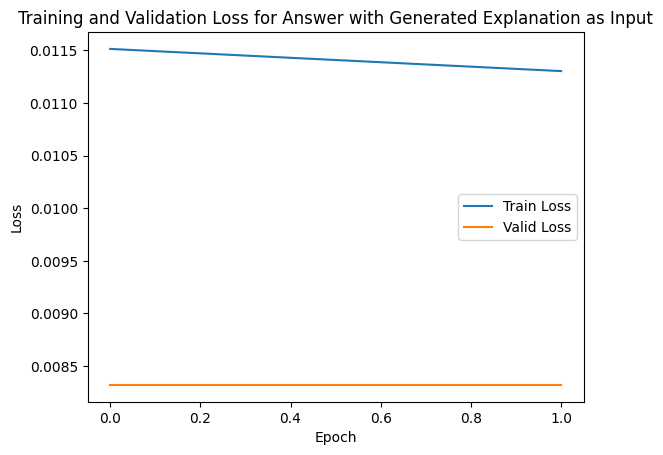

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(train_loss[1:5], label='Train Loss')
plt.plot(val_loss[1:5], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss for Answer with Generated Explanation as Input")
plt.legend()
plt.show()

In [ ]:
# %mkdir models_saved

In [ ]:
#Parameters for answer only model
input_max_len = 512
target_max_len = 128
num_epochs = 10
# learning_rate = 1e-5
train_batch_size = 8
val_batch_size = 8
# no_of_training_steps = 10000
# no_of_warmup_steps = 500
model_name = f"t5small_answer_model2_{input_max_len}_{target_max_len}_{num_epochs}_{train_batch_size}_{val_batch_size}"

In [ ]:
#Answer only model
model.save_pretrained(f"./textvqa/models_saved/{model_name}", from_pt=True)

In [ ]:
#evaluating the text generation on training set
model.eval()
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=data_collator)

model_answers_train = []
target_answers_train = []

with torch.no_grad():
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            #decoder_attention_mask=target_attention_mask,
            max_length=512,
            num_beams=10,
            early_stopping=True
        )
        
        # Convert the generated output to text
        output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        target_text = tokenizer.batch_decode(target_ids, skip_special_tokens=True)
        # print(output_text)
        # print("--")
        # print(target_text)
        model_answers_train.append(output_text)
        target_answers_train.append(target_text)

100%|██████████| 3028/3028 [25:55<00:00,  1.95it/s]


In [ ]:
with open('./textvqa/model2_answers_train', 'wb') as handle:
    pickle.dump(model_answers_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./textvqa/model2_target_answers_train', 'wb') as handle:
    pickle.dump(target_answers_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model_answers_train_overall,target_answers_train_overall=sum(model_answers_train,[]),sum(target_answers_train,[])
accuracy_boolean_train=[a.lower().split("explanation:")[0].strip()==b.lower().split("explanation:")[0].strip() for a,b in zip((model_answers_train_overall),(target_answers_train_overall))]
acc_train=(sum(accuracy_boolean_train)/len(accuracy_boolean_train))*100
print(f"The training accuracy of the model is {acc_train:.2f} %")

The training accuracy of the model is 65.92 %


In [ ]:
sum(model_answers_train,[])[0].split("explanation:")[0]

"answer: ['douglas adams']"

In [ ]:
model_answers_train_overall,target_answers_train_overall=sum(model_answers_train,[]),sum(target_answers_train,[])
accuracy_boolean_train=[a.lower().split("answer:")[1].strip()==b.lower().split("answer:")[1].strip() for a,b in zip((model_answers_train_overall),(target_answers_train_overall))]
acc_train=(sum(accuracy_boolean_train)/len(accuracy_boolean_train))*100
print(f"The training accuracy of the model is {acc_train:.2f} %")

The training accuracy of the model is 64.17 %


In [ ]:
model.eval()
valid_dataloader = DataLoader(valid_dataset, batch_size=8, collate_fn=data_collator)

model_answers = []
target_answers = []

with torch.no_grad():
    for batch in tqdm(valid_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            # decoder_attention_mask=target_attention_mask,
            max_length=512,
            num_beams=10,
            early_stopping=True
        )
        
        # Convert the generated output to text
        output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        target_text = tokenizer.batch_decode(target_ids, skip_special_tokens=True)
        model_answers.append(output_text)
        target_answers.append(target_text)

100%|██████████| 625/625 [05:21<00:00,  1.95it/s]


In [ ]:
with open('./textvqa/model1_model_answers', 'wb') as handle:
    pickle.dump(model_answers, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./textvqa/model1_target_answers', 'wb') as handle:
    pickle.dump(target_answers, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model_answers_overall,target_answers_overall=sum(model_answers,[]),sum(target_answers,[])

accuracy_boolean_valid = [a.lower().split("answer:")[1].strip()==b.lower().split("answer:")[1].strip() for a,b in zip((model_answers_overall),(target_answers_overall))]
acc_train=(sum(accuracy_boolean_valid)/len(accuracy_boolean_valid))*100
print(f"The validation accuracy of the model is {acc_train:.2f} %")

The validation accuracy of the model is 62.66 %
